# Exercise 1

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
% matplotlib inline
import os
import pandas as pd

In [2]:
# Plot output defaults
IMG_DIR = 'img'
IMG_FORMAT = 'pdf'
IMG_WIDTH = 7 # inches

In [3]:
def save_fig(fig, name, width=IMG_WIDTH, img_dir=IMG_DIR, img_format=IMG_FORMAT):
    """Save `matplotlib.figure.Figure` instance, resized to the specified width"""
    # Resize
    w, h = fig.get_size_inches()
    fig.set_size_inches(width, width/w * h)
    
    fname = '.'.join((os.path.join(img_dir, name), img_format))
    fig.savefig(fname)
    print('Saved:',fname)

In [4]:
df = pd.read_csv('data/RaPiD-10-1P_M_barleeanuum.csv', index_col=0)

## Question 1
**(~100 words; 10 marks)**

Provided with these equations and data for $\mathrm{\delta^{18}O}$ and Mg/Ca for *M. barleeanuum*, calculate
bottom water $\mathrm{\delta^{18}O_{SW}}$ values for the past 20 ka at site RAPiD-10-1P. Make a plot of T and $\mathrm{\delta^{18}O_{SW}}$.
Have you rejected any of the Mg/Ca measurements? If so, why?

### Reject measurements
According to Barker et al (2003),  Mg/Ca measurements are determined to be "potentially significantly contaminated" by clay silicates (which can be high in Mg) if the Fe/Mg ratio exceeds 0.1, so measurements here *could* be rejected on the criteria:
$$
\frac{Fe/Ca}{Mg/Ca} > 0.1 \, \mathrm{mol \cdot mol^{-1}}
$$

However, rather apply this criteria naively, it is useful to visually assess the magnitude of possible contamination criteria first.

#### Visualise contamination

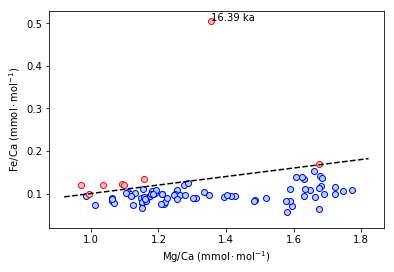

In [5]:
df2 = df[['Mg_Ca', 'Fe_Ca']]

# Identify potential contamination
fe_mg = df2['Fe_Ca']/df2['Mg_Ca'] # Fe/Mg
thresh = 0.1
is_contam = fe_mg > thresh
is_reject = fe_mg == max(fe_mg) # worst offender only

contam = df2[is_contam]
clean = df2[~is_contam]
reject = df2[is_reject]

# Visualise potential contamination
fig, ax = plt.subplots()

ax.scatter(clean['Mg_Ca'], clean['Fe_Ca'],
           facecolors='lightblue', edgecolors='blue') 
ax.scatter(contam['Mg_Ca'], contam['Fe_Ca'],
           facecolors='pink', edgecolors='red')
xlim = ax.get_xlim()
ax.plot(xlim, [x * thresh for x in xlim], 'k--') # contamination line

# Reject the most contaminated measurements
for age, xy in reject.iterrows():
    ax.annotate("{:.2f} ka".format(age), xy)
ax.set_xlabel('Mg/Ca ($\mathrm{mmol \cdot mol^{-1}}$)')
ax.set_ylabel('Fe/Ca ($\mathrm{mmol \cdot mol^{-1}}$)')

In [6]:
save_fig(fig, 'scatter_MgCa_x_FeCa_contaminated')

Saved: img/scatter_MgCa_x_FeCa_contaminated.pdf


### Calculate $\mathrm{\delta^{18}O_{SW}}$

The past 20 ka bottom water oxygen isotope signal, $\mathrm{\delta^{18}O_{SW}}$, can be calculated using:

$$
\delta^{18}O_{SW} = \delta^{18}O_{C} + 0.27 - \frac{4.38 - \sqrt{4.38^2 - 4 * 0.1(16.9 - T)}}{2 * 0.1} - \delta^{18}O_{ice}
$$

Where $\delta^{18}O_{C}$ is the raw signal in benthic foram carbonate, $\delta^{18}O_{ice}$ is the ice volume correction, and $T$ is the temperature of calcification determined from an indepent Mg/Ca proxy via:

$$
T = \frac{Mg/Ca - 0.96}{0.12}
$$

In [7]:
df['Temp'] = (df.Mg_Ca - 0.96)/0.12 # calcification temperature
# Bottom water delta-18-O
df['d18Osw'] = df.d18Oc + 0.27 - (4.38 - (4.38**2 - 4 * 0.1 * (16.9 - df.Temp))**0.5)/ (2*0.1) - df.d18Oice

In [8]:
# Ignore rejected value(s)
reject = df[is_reject]
df = df.mask(is_reject)

### Plot $T$ and $\delta^{18}O_{SW}$

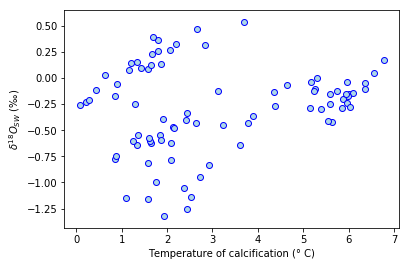

In [9]:
# Temp x d180sw
fig, ax = plt.subplots()
ax.scatter(df['Temp'], df['d18Osw'],
           facecolors='lightblue', edgecolors='blue')
ax.set_xlabel('Temperature of calcification (\u00B0 C)')
ax.set_ylabel('$\delta^{18}O_{SW}$ (\u2030)')

In [10]:
save_fig(fig, 'scatter_temp_x_d18Osw')

Saved: img/scatter_temp_x_d18Osw.pdf


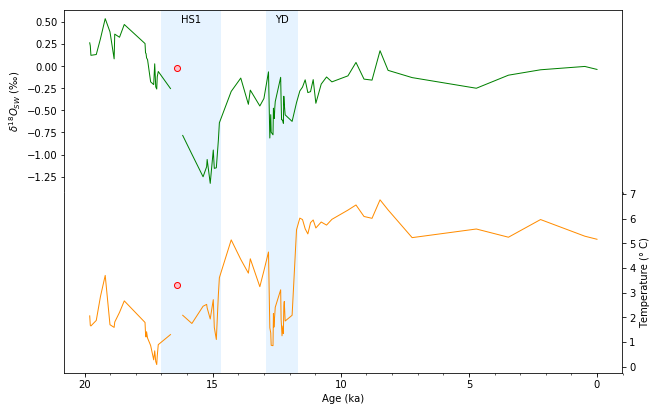

In [11]:
# Time series
fig, axes = plt.subplots(2, sharex=True, figsize=(10,10/1.5))

lines = axes[0].plot(df['d18Osw'], c='green', linewidth=1)
axes[0].scatter(reject.index, reject['d18Osw'],
                facecolors='pink', edgecolors='red',
                zorder=axes[0].lines[0].get_zorder()+1)
axes[0].set_ylabel('$\delta^{18}O_{SW}$ (\u2030)')
axes[0].spines['bottom'].set_visible(False)
axes[0].tick_params('x', bottom=False)
#axes[0].patch.set_visible(False)
#axes[0].yaxis.set_minor_locator(MultipleLocator(0.25))

axes[1].plot(df['Temp'], c='darkorange', linewidth=1)
axes[1].scatter(reject.index, reject['Temp'],
                facecolors='pink', edgecolors='red',
                zorder=axes[0].lines[0].get_zorder()+1)
axes[1].set_ylabel('Temperature (\u00B0 C)')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')
#axes[1].patch.set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].xaxis.set_minor_locator(MultipleLocator(1))
axes[1].xaxis.set_major_locator(MultipleLocator(5))
# Mark stadials
for i, (period, bounds) in enumerate([('HS1', (14.7, 17)),
                                      ('YD', (12.9, 11.7))]):
    for j, ax in enumerate(axes):
        ax.axvspan(*bounds, color='#e6f3ff', zorder=i+j)
        if not j:
            xy = ((bounds[0]+bounds[1])/2, ax.get_ylim()[1]-0.05)
            ax.annotate(period, xy, ha='center', va='top')
    
ax.set_xlabel('Age (ka)')
plt.gca().invert_xaxis()
fig.subplots_adjust(hspace=0)

In [12]:
save_fig(fig, 'timeseries_temp_and_d18Osw')

Saved: img/timeseries_temp_and_d18Osw.pdf
